# 数据挖掘互评作业四：离群点分析与异常检测

## 1.数据预览(数据集wine)

首先将文件夹下所有数据集的路径读取出来，然后展示第一个数据集的数据

In [1]:
import os
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.utils import column_or_1d,check_consistent_length
from sklearn.metrics import roc_auc_score,precision_score
from pyod.utils.utility import precision_n_scores
import warnings
warnings.filterwarnings("ignore")
root_path = 'wine\\benchmarks'
file_list=[]
for file in os.listdir(root_path):
    file_path = os.path.join(root_path,file)
    file_list.append(file_path)
data = pd.read_csv(file_list[0])
data.head(5)

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


数据集中ground.truth是标签属性，其中nominal代表正常点，anomaly代表异常点，fixed.acidity、volatile.acidity、citric.acid、residual.sugar、chlorides、free.sulfur.dioxide、total.sulfur.dioxide、density、pH、sulphates	alcohol是特征属性，接下来进一步查看各个属性的详细情况

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3703 entries, wine_point_3594 to wine_point_5748
Data columns (total 16 columns):
motherset               3703 non-null object
origin                  3703 non-null object
original.label          3703 non-null int64
diff.score              3703 non-null float64
ground.truth            3703 non-null object
fixed.acidity           3703 non-null float64
volatile.acidity        3703 non-null float64
citric.acid             3703 non-null float64
residual.sugar          3703 non-null float64
chlorides               3703 non-null float64
free.sulfur.dioxide     3703 non-null float64
total.sulfur.dioxide    3703 non-null float64
density                 3703 non-null float64
pH                      3703 non-null float64
sulphates               3703 non-null float64
alcohol                 3703 non-null float64
dtypes: float64(12), int64(1), object(3)
memory usage: 491.8+ KB


可以看出不存在缺失值，不需要进行缺失值处理

## 2.数据可视化

由于该数据集特征维数特别高，因此采用TSNE降维的方式可视化数据集，可以看出由于维数特别高，降维到二维很难将离群点与正常点划分开

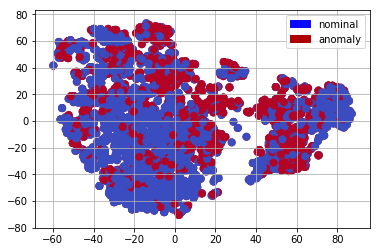

In [4]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
att = ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']
blue_patch = mpatches.Patch(color='#0A0AFF', label='nominal')
red_patch = mpatches.Patch(color='#AF0000', label='anomaly')
X = data[att].values
y = data['ground.truth'].values
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 'nominal'), cmap='coolwarm', label='Normal', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 'anomaly'), cmap='coolwarm', label='Fraud', linewidths=2)
plt.grid(True)
plt.legend(handles=[blue_patch, red_patch])

## 3.离群点预测

对于这个数据集我们同样采用Histogram-based Outlier Score(HBOS)、Isolation Forest(IF)、k Nearest Neighbors(KNN)、Local Outlier Factor(LOF)、Minimum Covariance Determinant(MCD)、Principal Component Analysis(PCA)六种算法分别对每个数据集进行训练和预测。

In [ ]:
classifiers_name = ['HBOS','IF','KNN','LOF','MCD','PCA'] 
att = ['fixed.acidity','volatile.acidity','citric.acid','residual.sugar','chlorides','free.sulfur.dioxide','total.sulfur.dioxide','density','pH','sulphates','alcohol']
res = {}
for name in classifiers_name:
    res[name] = {}
    res[name]['roc'] = []
    res[name]['rank_n'] = []
    res[name]['time'] = []
for i,path in enumerate(file_list):
    data = pd.read_csv(path,index_col=0)
    x = data[att].values
    y = data['ground.truth'].values
    y = np.where(y == 'nominal',0,1)
    X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state = 22,stratify=y)
    outliers_fraction = sum(y_train==1) / len(y_train)
    if outliers_fraction > 0.5:
        continue
    classifiers = {
    'HBOS': HBOS(contamination=outliers_fraction),
    'IF': IForest(contamination=outliers_fraction,random_state = 42),
    'KNN': KNN(contamination=outliers_fraction),
    'LOF':LOF(n_neighbors=35, contamination=outliers_fraction),
    'MCD': MCD(contamination=outliers_fraction, random_state=42),
    'PCA': PCA(contamination=outliers_fraction, random_state=42),
    }
    for clf_name in classifiers:
        start_time = time.time()
        clf = classifiers[clf_name]
        clf.fit(X_train)
        y_test_pred = clf.predict(X_test) 
        y_test_scores = clf.decision_function(X_test) 
        y = column_or_1d(y_test)
        y_pred = column_or_1d(y_test_scores)
        check_consistent_length(y, y_pred)
        roc = np.round(roc_auc_score(y, y_pred), decimals=4)
        prn = np.round(precision_n_scores(y, y_pred), decimals=4)
        run_time = time.time()-start_time
        res[clf_name]['roc'].append(roc)
        res[clf_name]['rank_n'].append(prn)
        res[clf_name]['time'].append(run_time)

对所有数据集分别使用以上六种算法进行训练预测，并保存每个数据集的aug分数，rank_n精度和算法运行时间

## 4.结果可视化

可视化每个算法在单个数据集上的平均aug分数，rank_n精度和算法运行时间

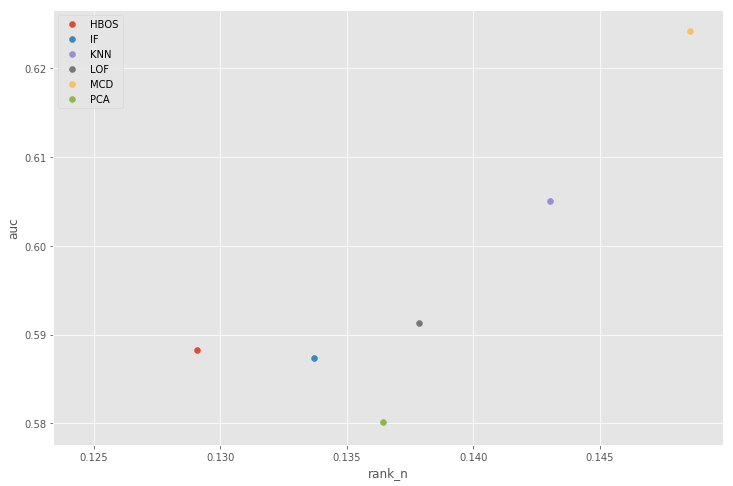

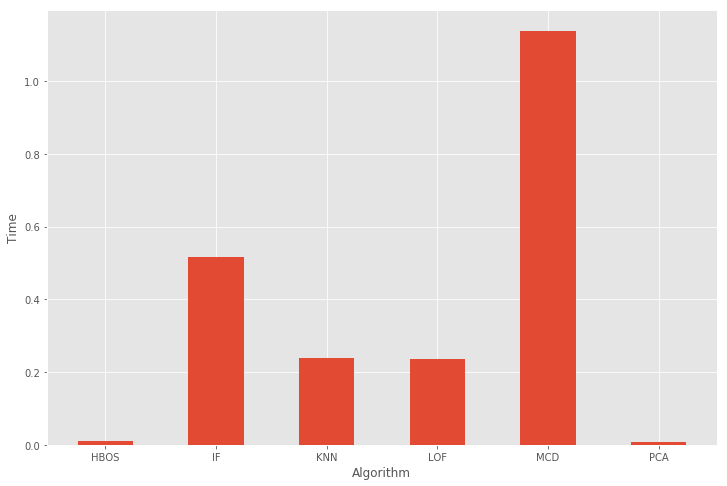

In [4]:
plt.style.use('ggplot')
plt.figure(figsize=(12,8))
name = res.keys()
all_time = []
for v in res.values():
    rank_n = np.mean(v['rank_n'])
    roc = np.mean(v['roc'])
    all_time.append(np.mean(v['time']))
    plt.scatter(rank_n,roc)
plt.xlabel("rank_n")
plt.ylabel("auc")
plt.legend(name)
plt.show()

plt.figure(figsize=(12,8))
plt.bar(name, all_time ,width=0.5)
plt.xlabel("Algorithm")
plt.ylabel("Time")
plt.show()

## 5.结果分析

可以看出MCD算法效果明显由于其他算法，但是他的运行时间也是最长的，KNN有着较好的效果，而且算法执行时间也比较短，因此对于小数据集来说使用MCD算法明显更好，而对于较大规模的数据集来说KNN也是比较不错的选择